In [14]:
#This project studies the Covid Data from Day Zero to 2021 in Singapore and Canada
#We will be first getting the API from https://api.covid19api.com/total/country/singapore
#Next create JSON file with all the data from the API
#Use Spark to analyze the JSON file

import requests
import json

def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    return text

#just to see how the data looks like 
#response = requests.get("https://api.covid19api.com/total/country/singapore")
#jprint(response.json())

#write to the new json file 
def write_to_file():
    output_file = "/Users/Vaahsan/SparkCourse/SingaporeCovidData.json"
    #get the JSON file here
    response = requests.get("https://api.covid19api.com/total/country/singapore")
    with open(output_file, 'a') as f:
        #write the text printed from jprint nicely to a file 
        f.write(jprint(response.json()))# Creating a JSON String from a dict object
        f.write("\n") # Appending new line at the end of the JSON record
    return output_file

write_to_file()

'/Users/Vaahsan/SparkCourse/SingaporeCovidData.json'

In [1]:
#initialize pyspark session need do this for Jupyter Notebook only
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql.functions import to_date,col,date_format,year,month,dayofmonth

spark = SparkSession.builder.appName("APIs").getOrCreate()

#spark.read only accepts (1) RDD, (2) List , (3) File Path
df = spark.read.option("multiline","true").json("file:///Users/Vaahsan/SparkCourse/SingaporeCovidData.json")

df2 = df.withColumn("year",year(col("Date"))).withColumn("month",month(col("Date"))).withColumn("day",dayofmonth(col("Date"))).withColumn("ProperDate",to_date(col("Date"))).withColumn("month_year",date_format(col("Date"),"yyyy-MM")).withColumn("month_year_datetype",to_date("month_year"))

df2.printSchema()
#all columns in dataframe 

root
 |-- Active: long (nullable = true)
 |-- City: string (nullable = true)
 |-- CityCode: string (nullable = true)
 |-- Confirmed: long (nullable = true)
 |-- Country: string (nullable = true)
 |-- CountryCode: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Deaths: long (nullable = true)
 |-- Lat: string (nullable = true)
 |-- Lon: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- Recovered: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- ProperDate: date (nullable = true)
 |-- month_year: string (nullable = true)
 |-- month_year_datetype: date (nullable = true)



In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime




In [3]:
#Active Cases Singapore 2020 vs 2021

df2 = df2.groupBy("month_year_datetype").avg("Active").sort(col("month_year_datetype").asc()).select("*")
df2p = df2.toPandas()

(array([737425., 737485., 737546., 737607., 737669., 737730., 737791.,
        737850., 737911., 737972.]), <a list of 10 Text xticklabel objects>)

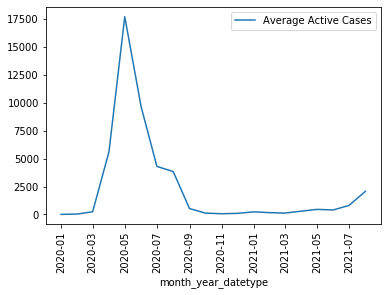

In [5]:
ax = plt.gca()

df2p.plot(x = 'month_year_datetype',y = "avg(Active)", label = "Average Active Cases" , ax = ax)
plt.xticks(rotation=90)

#trend active cases over time per month
#May was the highest spike attributed mainly to huge number domitory cases as reported in 
#https://www.channelnewsasia.com/singapore/covid-19-migrant-workers-dormitories-discharged-circuit-breaker-937606

In [8]:
#Here we want to see the trend comparison with Singapore bound incoming flights vs covid cases 

#csv file has redundant rows, need delete first
#used skip first 4 rows
cs = pd.read_csv('/Users/Vaahsan/Downloads/ChangiAirport_Monthly.csv',skiprows = 4)
#deleted redundant rows below and last column
cs1 = cs.drop(range(10,24)).drop(labels="Unnamed: 499",axis=1)
#set variables as index first so later when transpose wont have 0 ,1,2,3,4 as the header 
cs1T = cs1.set_index(" Variables ").T

#variables was the index, use reset to make the date time column come out 
cs1T = cs1T.reset_index()

#change object to date time where format you can look up the glossary https://strftime.org/
#this will give standard output of YYYY-MM-DD
cs1T["index"] = pd.to_datetime(cs1T["index"],format = " %Y %b ")

#cos the total aircraft columns all are strings with , -> need to remove it first so that can change to int later
cs1T = cs1T.replace(',','', regex=True)

#change col type from string to int/float , specific col
cs1T[" Total Aircraft Arrivals And Departures (Number) "] = pd.to_numeric(cs1T[" Total Aircraft Arrivals And Departures (Number) "])

#rename col to match other dataset
cs1T = cs1T.rename(columns={"index":"month_year_datetype"})

print(cs1T.dtypes)

#Show all columns in dataset 

 Variables 
month_year_datetype                                  datetime64[ns]
 Total Aircraft Arrivals And Departures (Number)              int64
     Aircraft Arrivals * (Number)                            object
     Aircraft Departures * (Number)                          object
 Total Passengers * (Number)                                 object
     Passengers Arriving (Number)                            object
     Passengers Departing (Number)                           object
     Passengers In Transit * (Number)                        object
 Total Mail * (Tonne)                                        object
     In-coming Mail * (Tonne)                                object
     Out-going Mail * (Tonne)                                object
dtype: object


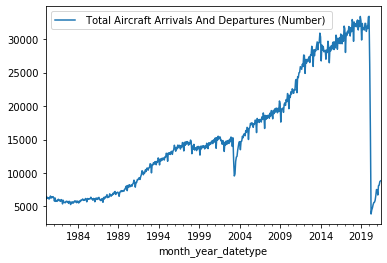

In [9]:
#We can see flight arrivals and depature hit at all time low at the start of the year, resembling times similar to 1980s

cs1T.plot(x = 'month_year_datetype',y = " Total Aircraft Arrivals And Departures (Number) ")


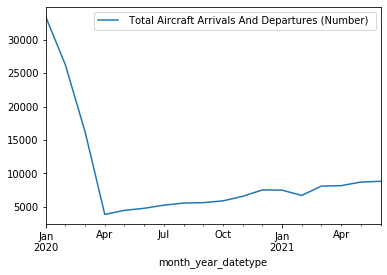

In [10]:
#get rows starting 2020
cs1T = cs1T[cs1T["month_year_datetype"]> "2019-12-01"]

cs1T.plot(x = 'month_year_datetype',y = " Total Aircraft Arrivals And Departures (Number) ")

#flights vs time trend chart filtering so end 2019 onwards 

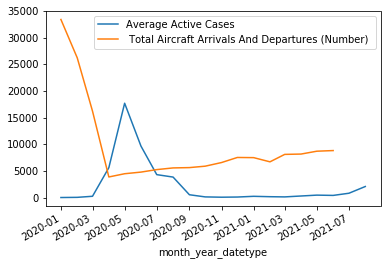

In [11]:
#see the trend comparison with flights vs covid cases 

ax = plt.gca()

df2p.plot(x = 'month_year_datetype',y = "avg(Active)", label = "Average Active Cases" , ax = ax)
cs1T.plot(x = 'month_year_datetype',y = " Total Aircraft Arrivals And Departures (Number) ",ax = ax)

#Just as the covid cases started to increase rapidly, flights were also increasingly reduced showing there was a strong correlation
#between international flights and number of local active covid cases 